<a href="https://colab.research.google.com/github/deepshikharbhardwaj/ML-2-BackPropogation/blob/main/ML2_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install torch

In [10]:
import torch
import torch.nn as nn

# RBF Layer

class RBF(nn.Module):
    """
    Transforms incoming data using a given radial basis function:
    u_{i} = rbf(||x - c_{i}|| / s_{i})
    Arguments:
        in_features: size of each input sample
        out_features: size of each output sample
    Shape:
        - Input: (N, in_features) where N is an arbitrary batch size
        - Output: (N, out_features) where N is an arbitrary batch size
    Attributes:
        centres: the learnable centres of shape (out_features, in_features).
            The values are initialised from a standard normal distribution.
            Normalising inputs to have mean 0 and standard deviation 1 is
            recommended.
        
        sigmas: the learnable scaling factors of shape (out_features).
            The values are initialised as ones.
        
        basis_func: the radial basis function used to transform the scaled
            distances.
    """

    def __init__(self, in_features, out_features, basis_func):
        super(RBF, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.centres = nn.Parameter(torch.Tensor(out_features, in_features))
        self.sigmas = nn.Parameter(torch.Tensor(out_features))
        self.basis_func = basis_func
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.normal_(self.centres, 0, 1)
        nn.init.constant_(self.sigmas, 1)

    def forward(self, input):
        size = (input.size(0), self.out_features, self.in_features)
        x = input.unsqueeze(1).expand(size)
        c = self.centres.unsqueeze(0).expand(size)
        distances = (x - c).pow(2).sum(-1).pow(0.5) * self.sigmas.unsqueeze(0)
        return self.basis_func(distances)



# RBFs

def gaussian(alpha):
    phi = torch.exp(-1*alpha.pow(2))
    return phi

def linear(alpha):
    phi = alpha
    return phi

def quadratic(alpha):
    phi = alpha.pow(2)
    return phi

def inverse_quadratic(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2))
    return phi

def multiquadric(alpha):
    phi = (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def inverse_multiquadric(alpha):
    phi = torch.ones_like(alpha) / (torch.ones_like(alpha) + alpha.pow(2)).pow(0.5)
    return phi

def spline(alpha):
    phi = (alpha.pow(2) * torch.log(alpha + torch.ones_like(alpha)))
    return phi

def poisson_one(alpha):
    phi = (alpha - torch.ones_like(alpha)) * torch.exp(-alpha)
    return phi

def poisson_two(alpha):
    phi = ((alpha - 2*torch.ones_like(alpha)) / 2*torch.ones_like(alpha)) \
    * alpha * torch.exp(-alpha)
    return phi

def matern32(alpha):
    phi = (torch.ones_like(alpha) + 3**0.5*alpha)*torch.exp(-3**0.5*alpha)
    return phi

def matern52(alpha):
    phi = (torch.ones_like(alpha) + 5**0.5*alpha + (5/3) \
    * alpha.pow(2))*torch.exp(-5**0.5*alpha)
    return phi

def basis_func_dict():
    """
    A helper function that returns a dictionary containing each RBF
    """
    
    bases = {'gaussian': gaussian,
             'linear': linear,
             'quadratic': quadratic,
             'inverse quadratic': inverse_quadratic,
             'multiquadric': multiquadric,
             'inverse multiquadric': inverse_multiquadric,
             'spline': spline,
             'poisson one': poisson_one,
             'poisson two': poisson_two,
             'matern32': matern32,
             'matern52': matern52}
    return bases

Epoch: 5000, Progress: 200/200, Loss: 0.003172      

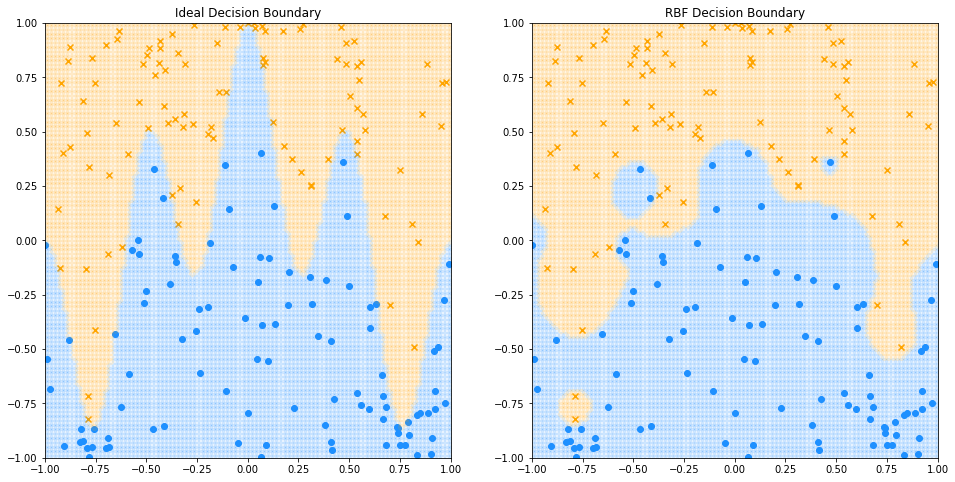

In [13]:

#import torch_rbf as rbf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sys
import numpy as np
import matplotlib.pyplot as plt

# Defining an RBF network class

class MyDataset(Dataset):
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.size(0)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return (x, y)

class Network(nn.Module):
    
    def __init__(self, layer_widths, layer_centres, basis_func):
        super(Network, self).__init__()
        self.rbf_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()
        for i in range(len(layer_widths) - 1):
            self.rbf_layers.append(RBF(layer_widths[i], layer_centres[i], basis_func))
            self.linear_layers.append(nn.Linear(layer_centres[i], layer_widths[i+1]))
    
    def forward(self, x):
        out = x
        for i in range(len(self.rbf_layers)):
            out = self.rbf_layers[i](out)
            out = self.linear_layers[i](out)
        return out
    
    def fit(self, x, y, epochs, batch_size, lr, loss_func):
        self.train()
        obs = x.size(0)
        trainset = MyDataset(x, y)
        trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
        optimiser = torch.optim.Adam(self.parameters(), lr=lr)
        epoch = 0
        while epoch < epochs:
            epoch += 1
            current_loss = 0
            batches = 0
            progress = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                y_hat = self.forward(x_batch)
                loss = loss_func(y_hat, y_batch)
                current_loss += (1/batches) * (loss.item() - current_loss)
                loss.backward()
                optimiser.step()
                progress += y_batch.size(0)
                sys.stdout.write('\rEpoch: %d, Progress: %d/%d, Loss: %f      ' % \
                                 (epoch, progress, obs, current_loss))
                sys.stdout.flush()



# Generating a dataset for a given decision boundary

x1 = np.linspace(-1, 1, 101)
x2 = 0.5*np.cos(np.pi*x1) + 0.5*np.cos(4*np.pi*(x1+1)) # <- decision boundary

samples = 200
x = np.random.uniform(-1, 1, (samples, 2))
for i in range(samples):
    if i < samples//2:
        x[i,1] = np.random.uniform(-1, 0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)))
    else:
        x[i,1] = np.random.uniform(0.5*np.cos(np.pi*x[i,0]) + 0.5*np.cos(4*np.pi*(x[i,0]+1)), 1)

steps = 100
x_span = np.linspace(-1, 1, steps)
y_span = np.linspace(-1, 1, steps)
xx, yy = np.meshgrid(x_span, y_span)
values = np.append(xx.ravel().reshape(xx.ravel().shape[0], 1),
                   yy.ravel().reshape(yy.ravel().shape[0], 1),
                   axis=1)

tx = torch.from_numpy(x).float()
ty = torch.cat((torch.zeros(samples//2,1), torch.ones(samples//2,1)), dim=0)



# Instanciating and training an RBF network with the Gaussian basis function
# This network receives a 2-dimensional input, transforms it into a 40-dimensional
# hidden representation with an RBF layer and then transforms that into a
# 1-dimensional output/prediction with a linear layer

# To add more layers, change the layer_widths and layer_centres lists

layer_widths = [2, 1]
layer_centres = [40]
basis_func = gaussian

rbfnet = Network(layer_widths, layer_centres, basis_func)
rbfnet.fit(tx, ty, 5000, samples, 0.01, nn.BCEWithLogitsLoss())
rbfnet.eval()



# Plotting the ideal and learned decision boundaries

with torch.no_grad():
    preds = (torch.sigmoid(rbfnet(torch.from_numpy(values).float()))).data.numpy()
ideal_0 = values[np.where(values[:,1] <= 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
ideal_1 = values[np.where(values[:,1] > 0.5*np.cos(np.pi*values[:,0]) + 0.5*np.cos(4*np.pi*(values[:,0]+1)))[0]]
area_0 = values[np.where(preds[:, 0] <= 0.5)[0]]
area_1 = values[np.where(preds[:, 0] > 0.5)[0]]

fig, ax = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
ax[0].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[0].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[0].scatter(ideal_0[:, 0], ideal_0[:, 1], alpha=0.1, c='dodgerblue')
ax[0].scatter(ideal_1[:, 0], ideal_1[:, 1], alpha=0.1, c='orange')
ax[0].set_xlim([-1,1])
ax[0].set_ylim([-1,1])
ax[0].set_title('Ideal Decision Boundary')
ax[1].scatter(x[:samples//2,0], x[:samples//2,1], c='dodgerblue')
ax[1].scatter(x[samples//2:,0], x[samples//2:,1], c='orange', marker='x')
ax[1].scatter(area_0[:, 0], area_0[:, 1], alpha=0.1, c='dodgerblue')
ax[1].scatter(area_1[:, 0], area_1[:, 1], alpha=0.1, c='orange')
ax[1].set_xlim([-1,1])
ax[1].set_ylim([-1,1])
ax[1].set_title('RBF Decision Boundary')
plt.show()